## demo data v2

```
'samples/npy_v2\\aespa2_motion1_73_328.npy', 'samples/npy_v2\\aespa2_motion2_350_582.npy', 'samples/npy_v2\\aespa2_motion3_582_847.npy', 'samples/npy_v2\\aespa2_motion4_870_1120.npy', 'samples/npy_v2\\aespa2_motion5_1356_1507.npy', 'samples/npy_v2\\aespa4_motion1_66_328.npy', 'samples/npy_v2\\aespa4_motion2_349_583.npy', 'samples/npy_v2\\aespa4_motion3_583_845.npy', 'samples/npy_v2\\aespa4_motion4_866_1119.npy', 'samples/npy_v2\\aespa4_motion5_1345_1502.npy', 'samples/npy_v2\\bts2_motion3_1343_1714.npy', 'samples/npy_v2\\bts2_motion4_1716_1907.npy', 'samples/npy_v2\\bts3_motion3_1419_1789.npy', 'samples/npy_v2\\bts3_motion4_1790_2018.npy', 'samples/npy_v2\\itzy6_motion1_34_193.npy', 'samples/npy_v2\\itzy6_motion2_557_716.npy', 'samples/npy_v2\\itzy6_motion3_825_1088.npy', 'samples/npy_v2\\itzy7_motion1_25_196.npy', 'samples/npy_v2\\itzy7_motion2_550_708.npy', 'samples/npy_v2\\itzy7_motion3_820_1077.npy', 'samples/npy_v2\\jenny2_motion1_127_372.npy', 'samples/npy_v2\\jenny2_motion3_2400_2660.npy', 'samples/npy_v2\\jenny2_motion4_3373_3534.npy', 'samples/npy_v2\\jenny4_motion1_25_227.npy', 'samples/npy_v2\\jenny4_motion3_1775_2000.npy', 'samples/npy_v2\\jenny4_motion4_2730_2876.npy', 'samples/npy_v2\\twice3_motion1_13_211.npy', 'samples/npy_v2\\twice3_motion2_252_450.npy', 'samples/npy_v2\\twice3_motion3_460_683.npy', 'samples/npy_v2\\twice3_motion4_767_1018.npy', 'samples/npy_v2\\twice3_motion5_1025_1166.npy', 'samples/npy_v2\\twice5_motion1_19_226.npy', 'samples/npy_v2\\twice5_motion2_270_472.npy', 'samples/npy_v2\\twice5_motion3_484_712.npy', 'samples/npy_v2\\twice5_motion4_803_1065.npy', 'samples/npy_v2\\twice5_motion5_1074_1218.npy'
```

In [2]:
import os, sys
from glob import glob
import copy

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, RobustScaler

import math
from scipy import spatial
from scipy.stats import kurtosis
from scipy.stats import skew
import vptree

from matplotlib import pyplot as plt
import seaborn as sns

sys.path.insert(0, "utils/")
from preprocess import make_outlier_index_dict, get_successive_groups,\
                        apply_outlier_interp, apply_one_euro_filter, rescale_by_bbox,\
                            pose_preprocess, pose_preprocess_v2, l2_norm
from distance import weighted_distance_matching, simple_minus, simple_euc, simple_cosine, cosine_dist_xy_flatten#, euc_cosine_dist
from feature_extract import extract_feature_svd
from utils import summarize_vptree_result, rank_vptree_result, vptree_search
from visualize import visualize_joints
from object_type_conversion import object_type_conversion

from visualize import multi_displot
from one_euro_filter import LowPassFilter, OneEuroFilter, OneEuroFilterROMP
from scipy.spatial.distance import cosine

In [3]:
# base_dir = 'samples/npy/'
# pose_paths = sorted(glob(os.path.join(base_dir,'*_pose.npy')))
# bbox_paths = sorted(glob(os.path.join(base_dir,'*_bbox.npy')))

# print(len(pose_paths), len(bbox_paths))

# poses = [np.load(pose_paths[i], allow_pickle=True)[..., :2] for i in range(len(pose_paths))]
# bboxes = [np.load(bbox_paths[i], allow_pickle=True) for i in range(len(bbox_paths))]

# print(len(poses), len(bboxes))

In [4]:
pose_dir = 'samples/npy_v2'
bbox_dir = 'samples/npy'
pose_paths = sorted(glob(os.path.join(pose_dir,'*.npy')))
bbox_paths = sorted(glob(os.path.join(bbox_dir,'*_bbox.npy')))

print(len(pose_paths), len(bbox_paths))

poses = [np.load(pose_paths[i], allow_pickle=True)[..., :2] for i in range(len(pose_paths))]
# bboxes = [np.load(bbox_paths[i], allow_pickle=True) for i in range(len(bbox_paths))]

print(len(poses))

36 35
36


In [5]:
print(pose_paths)

['samples/npy_v2\\aespa2_motion1_73_328.npy', 'samples/npy_v2\\aespa2_motion2_350_582.npy', 'samples/npy_v2\\aespa2_motion3_582_847.npy', 'samples/npy_v2\\aespa2_motion4_870_1120.npy', 'samples/npy_v2\\aespa2_motion5_1356_1507.npy', 'samples/npy_v2\\aespa4_motion1_66_328.npy', 'samples/npy_v2\\aespa4_motion2_349_583.npy', 'samples/npy_v2\\aespa4_motion3_583_845.npy', 'samples/npy_v2\\aespa4_motion4_866_1119.npy', 'samples/npy_v2\\aespa4_motion5_1345_1502.npy', 'samples/npy_v2\\bts2_motion3_1343_1714.npy', 'samples/npy_v2\\bts2_motion4_1716_1907.npy', 'samples/npy_v2\\bts3_motion3_1419_1789.npy', 'samples/npy_v2\\bts3_motion4_1790_2018.npy', 'samples/npy_v2\\itzy6_motion1_34_193.npy', 'samples/npy_v2\\itzy6_motion2_557_716.npy', 'samples/npy_v2\\itzy6_motion3_825_1088.npy', 'samples/npy_v2\\itzy7_motion1_25_196.npy', 'samples/npy_v2\\itzy7_motion2_550_708.npy', 'samples/npy_v2\\itzy7_motion3_820_1077.npy', 'samples/npy_v2\\jenny2_motion1_127_372.npy', 'samples/npy_v2\\jenny2_motion3_240

In [6]:
vid_motion_index = {}
error_vidnames, error_indices = [], []

pose_paths_new = []

for i, pp in enumerate(pose_paths):
    poselen = len(poses[i])

    bname = os.path.basename(pp)
    bname_split = bname.split('_')

    vidname = bname_split[0]
    motname= bname_split[1]
    start_index = int(bname_split[2])
    end_index = int(bname_split[3].split('.')[0])
    if poselen == (end_index - start_index):
        if vidname not in vid_motion_index:
            vid_motion_index[vidname] = {}
        if motname not in vid_motion_index[vidname]:
            vid_motion_index[vidname][motname] = (start_index, end_index)
        pose_paths_new.append(pp)
    else:
        error_vidnames.append((vidname, motname))
        error_indices.append(i)
        print(vidname, motname, poselen, end_index - start_index)

    # if poselen != (end_index - start_index):

In [7]:
error_vidnames

[]

In [8]:
vid_motion_index

{'aespa2': {'motion1': (73, 328),
  'motion2': (350, 582),
  'motion3': (582, 847),
  'motion4': (870, 1120),
  'motion5': (1356, 1507)},
 'aespa4': {'motion1': (66, 328),
  'motion2': (349, 583),
  'motion3': (583, 845),
  'motion4': (866, 1119),
  'motion5': (1345, 1502)},
 'bts2': {'motion3': (1343, 1714), 'motion4': (1716, 1907)},
 'bts3': {'motion3': (1419, 1789), 'motion4': (1790, 2018)},
 'itzy6': {'motion1': (34, 193),
  'motion2': (557, 716),
  'motion3': (825, 1088)},
 'itzy7': {'motion1': (25, 196),
  'motion2': (550, 708),
  'motion3': (820, 1077)},
 'jenny2': {'motion1': (127, 372),
  'motion3': (2400, 2660),
  'motion4': (3373, 3534)},
 'jenny4': {'motion1': (25, 227),
  'motion3': (1775, 2000),
  'motion4': (2730, 2876)},
 'twice3': {'motion1': (13, 211),
  'motion2': (252, 450),
  'motion3': (460, 683),
  'motion4': (767, 1018),
  'motion5': (1025, 1166)},
 'twice5': {'motion1': (19, 226),
  'motion2': (270, 472),
  'motion3': (484, 712),
  'motion4': (803, 1065),
  'mo

In [9]:
bboxes = []

for i, (vidname, motiondict) in enumerate(vid_motion_index.items()):
    # print(vidname)
    bbox_path = [bp for bp in bbox_paths if vidname in bp][0]
    print(bbox_path)
    bbox = np.load(bbox_path, allow_pickle=True)

    if bbox.dtype == 'object':
        bbox = object_type_conversion(bbox)

    for motname, indices in motiondict.items():
        print(motname)
        bbox_slice = bbox[indices[0]:indices[1]]
        # print(vidname, motname, bbox_slice.shape)
        bboxes.append(bbox_slice)

samples/npy\aespa2_frames_bbox.npy
motion1
motion2
motion3
motion4
motion5
samples/npy\aespa4_frames_bbox.npy
motion1
motion2
motion3
motion4
motion5
samples/npy\bts2_frames_bbox.npy
motion3
motion4
samples/npy\bts3_frames_bbox.npy
motion3
motion4
samples/npy\itzy6_frames_bbox.npy
motion1
motion2
motion3
samples/npy\itzy7_frames_bbox.npy
motion1
motion2
motion3
samples/npy\jenny2_frames_bbox.npy
motion1
motion3
motion4
samples/npy\jenny4_frames_bbox.npy
motion1
motion3
motion4
samples/npy\twice3_frames_bbox.npy
motion1
motion2
motion3
motion4
motion5
samples/npy\twice5_frames_bbox.npy
motion1
motion2
motion3
motion4
motion5


### visualize

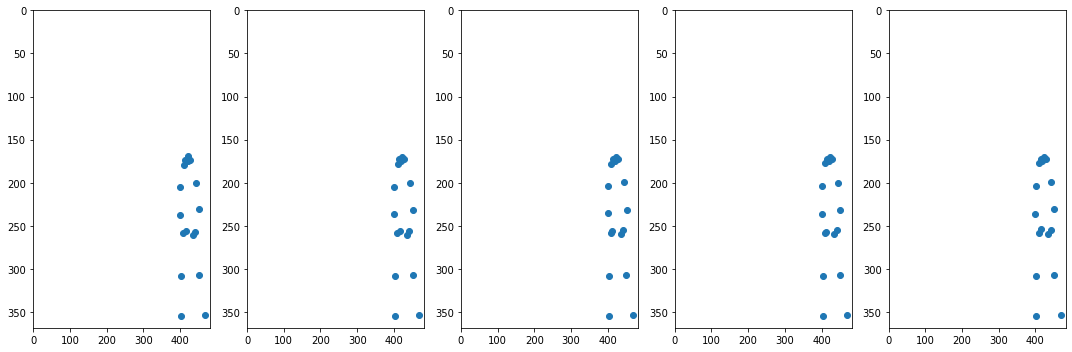

In [11]:
visualize_joints(poses[0][...,:2].reshape(-1, 34), 13, 18)

In [12]:
fnames = [f"{os.path.basename(p).split('_')[0]}_{os.path.basename(p).split('_')[1]}" for p in pose_paths]
query_names = ['aespa2', 'bts2', 'itzy6', 'jenny2', 'twice3']
matching_names = ['aespa4', 'bts3', 'itzy7', 'jenny4', 'twice5']

query_index = [i for i, fn in enumerate(fnames) if fn.split('_')[0] in query_names]
matching_index = [i for i, fn in enumerate(fnames) if fn.split('_')[0] in matching_names]

query_poses = [p for i, p in enumerate(poses) if i in query_index]
query_bboxes = [b for i, b in enumerate(bboxes) if i in query_index]
query_fnames = [f for i, f in enumerate(fnames) if i in query_index]

matching_poses = [p for i, p in enumerate(poses) if i in matching_index]
matching_bboxes = [b for i, b in enumerate(bboxes) if i in matching_index]
matching_fnames = [f for i, f in enumerate(fnames) if i in matching_index]

In [13]:
len(query_poses), len(query_bboxes), len(matching_poses), len(matching_bboxes), len(query_fnames), len(matching_fnames)

(18, 18, 18, 18, 18, 18)

In [14]:
poses1_prep, poses1_prep_norm = [], []
idx2vidname = {}

def preprocess(poses, bboxes, fnames):
    poses1_prep, poses1_prep_norm = [], []
    for i, (pose_, bbox) in enumerate(zip(poses, bboxes)):
        if len(pose_) != len(bbox):
            print(i, fnames[i], 'different length', len(pose_), len(bbox))
            continue

        ppose = pose_[...,:2]
        conf_score = pose_[...,-1]

        # print(len(ppose), len(bbox))
        
        ppose_xy = pose_preprocess(ppose, bbox, normalize=False)
        ppose_xy_norm = pose_preprocess(ppose, bbox, normalize=True)

        ppose_conf = np.concatenate([ppose_xy, conf_score, 
                                    np.sum(conf_score, axis=1).reshape(-1,1),
                                    np.array([i]*len(ppose)).reshape(-1,1)], axis=1) # add video unique index
        poses1_prep.append(ppose_conf)
        ########################################
        ppose_conf_norm = np.concatenate([ppose_xy_norm, conf_score, 
                                    np.sum(conf_score, axis=1).reshape(-1,1),
                                    np.array([i]*len(ppose)).reshape(-1,1)], axis=1) # add video unique index
        poses1_prep_norm.append(ppose_conf_norm)

        idx2vidname[i] = fnames[i]

    return poses1_prep, poses1_prep_norm

poses_prep, poses_prep_norm = preprocess(query_poses + matching_poses,\
                                         query_bboxes + matching_bboxes,\
                                            query_fnames + matching_fnames)

query_poses_prep, query_poses_prep_norm = poses_prep[:len(poses_prep)//2], poses_prep_norm[:len(poses_prep)//2]
matching_poses_prep, matching_poses_prep_norm = poses_prep[len(poses_prep)//2:], poses_prep_norm[len(poses_prep)//2:]

In [15]:
len(query_poses_prep), len(matching_poses_prep)

(18, 18)

In [16]:
print(idx2vidname)

{0: 'aespa2_motion1', 1: 'aespa2_motion2', 2: 'aespa2_motion3', 3: 'aespa2_motion4', 4: 'aespa2_motion5', 5: 'bts2_motion3', 6: 'bts2_motion4', 7: 'itzy6_motion1', 8: 'itzy6_motion2', 9: 'itzy6_motion3', 10: 'jenny2_motion1', 11: 'jenny2_motion3', 12: 'jenny2_motion4', 13: 'twice3_motion1', 14: 'twice3_motion2', 15: 'twice3_motion3', 16: 'twice3_motion4', 17: 'twice3_motion5', 18: 'aespa4_motion1', 19: 'aespa4_motion2', 20: 'aespa4_motion3', 21: 'aespa4_motion4', 22: 'aespa4_motion5', 23: 'bts3_motion3', 24: 'bts3_motion4', 25: 'itzy7_motion1', 26: 'itzy7_motion2', 27: 'itzy7_motion3', 28: 'jenny4_motion1', 29: 'jenny4_motion3', 30: 'jenny4_motion4', 31: 'twice5_motion1', 32: 'twice5_motion2', 33: 'twice5_motion3', 34: 'twice5_motion4', 35: 'twice5_motion5'}


### test1
* image similarity based search
    * sample interval = 10 / 20
* using weighted distance

In [17]:
queries = query_poses_prep_norm.copy()
matchings = matching_poses_prep_norm.copy()

data = np.concatenate(matchings)
queries[0].shape, data.shape

((255, 53), (3968, 53))

In [18]:
tree = vptree.VPTree(data, weighted_distance_matching)

In [19]:
result = tree.get_n_nearest_neighbors(queries[0][0], 10)
summarize_vptree_result(result, idx2vidname)

[('itzy7_motion1', 0.0163106191086391),
 ('itzy7_motion1', 0.017181936129846333),
 ('itzy7_motion1', 0.022039177800687797),
 ('aespa4_motion5', 0.022569747087311905),
 ('aespa4_motion5', 0.023111997647237727),
 ('aespa4_motion5', 0.023636559497211378),
 ('aespa4_motion5', 0.023974958604817898),
 ('aespa4_motion5', 0.024299367799390313),
 ('aespa4_motion5', 0.024360090464435543),
 ('aespa4_motion5', 0.02477115026455092)]

In [20]:
# query = aespa motion1
K = 0
print(idx2vidname[K])
vptree_search(tree, idx2vidname, queries[K], 0, len(queries[K]), 20, 5)

aespa2_motion1


[('aespa4_motion1', 7.31637879831445e+54),
 ('itzy7_motion1', 1.1742926069764768e+24),
 ('aespa4_motion5', 5.878308852224695e+19),
 ('bts3_motion4', 145842159668998.72),
 ('twice5_motion2', 3715555.296690578)]

In [281]:
# query = twice3 motion2
K = 1
print(idx2vidname[K])
vptree_search(tree, idx2vidname, queries[K], 0, len(queries[K]), 20, 5)

aespa2_motion2


[('aespa4_motion2', 7.221626800912986e+35),
 ('aespa4_motion4', 6.996876634828465e+18),
 ('twice5_motion4', 2.1266225359531986e+18),
 ('bts3_motion3', 562193656122.432),
 ('aespa4_motion1', 114357712400.57283)]

In [282]:
# query = twice3 motion3
K = 2
print(idx2vidname[K])
vptree_search(tree, idx2vidname, queries[K], 0, len(queries[K]), 20, 5)

aespa2_motion3


[('aespa4_motion3', 6.051035239919722e+72),
 ('bts3_motion3', 1.0391512841075747e+19),
 ('aespa4_motion5', 171215823067737.25),
 ('bts3_motion4', 8678708336.958443),
 ('twice5_motion2', 1998197.0280777907)]

In [308]:
# query = twice3 motion4
K = 3
print(idx2vidname[K])
vptree_search(tree, idx2vidname, queries[K], 0, len(queries[K]), 10, 5)

aespa2_motion4


[('aespa4_motion4', 2.5497784408625294e+187),
 ('twice5_motion4', 4.8641103289991896e+16),
 ('twice5_motion3', 40720867375173.48),
 ('bts3_motion3', 4553569034568.973),
 ('aespa4_motion1', 206387366.78286216)]

In [333]:
K = 4
print(idx2vidname[K])
vptree_search(tree, idx2vidname, queries[K], 0, len(queries[K]), 10, 5)

aespa2_motion5


[('jenny4_motion3', 4.539332528016639e+46),
 ('aespa4_motion5', 1.0160159258767425e+40),
 ('aespa4_motion1', 2.734316823468541e+23),
 ('bts3_motion3', 1.2868500787573294e+16),
 ('bts3_motion4', 152316771010.42093)]

In [288]:
K = 5
print(idx2vidname[K])
vptree_search(tree, idx2vidname, queries[K], 0, len(queries[K]), 20, 5)

bts2_motion3


[('bts3_motion3', 5.736868616215389e+111),
 ('bts3_motion4', 2.7159422006856447e+29),
 ('itzy7_motion2', 138984607841906.38),
 ('twice5_motion3', 291794408.95510614),
 ('itzy7_motion1', 7599925.143336248)]

In [289]:
K = 6
print(idx2vidname[K])
vptree_search(tree, idx2vidname, queries[K], 0, len(queries[K]), 20, 5)

bts2_motion4


[('bts3_motion4', 1.4990696134648611e+65),
 ('twice5_motion3', 730195809.851285),
 ('aespa4_motion1', 3355340.5943683945),
 ('aespa4_motion4', 617388.3939550956),
 ('aespa4_motion5', 89152.43298127613)]

In [337]:
K = 7
print(idx2vidname[K])
vptree_search(tree, idx2vidname, queries[K], 0, len(queries[K]), 15, 5)

itzy6_motion1


[('itzy7_motion1', 6.092340558149975e+21),
 ('aespa4_motion2', 1636191665297367.2),
 ('aespa4_motion4', 96842960540627.4),
 ('jenny4_motion3', 93434141587889.78),
 ('itzy7_motion3', 170798008889.59048)]

In [292]:
K = 8
print(idx2vidname[K])
vptree_search(tree, idx2vidname, queries[K], 0, len(queries[K]), 10, 5)

itzy6_motion2


[('itzy7_motion2', 4.6113138597950354e+55),
 ('aespa4_motion3', 4.2884345690572814e+29),
 ('bts3_motion3', 126636652661021.39),
 ('jenny4_motion3', 352666105130.04315),
 ('twice5_motion4', 3525523409.9309406)]

In [293]:
K = 8
print(idx2vidname[K])
vptree_search(tree, idx2vidname, queries[K], 0, len(queries[K]), 10, 5)

itzy6_motion2


[('itzy7_motion2', 4.6113138597950354e+55),
 ('aespa4_motion3', 4.2884345690572814e+29),
 ('bts3_motion3', 126636652661021.39),
 ('jenny4_motion3', 352666105130.04315),
 ('twice5_motion4', 3525523409.9309406)]

In [294]:
K = 9
print(idx2vidname[K])
vptree_search(tree, idx2vidname, queries[K], 0, len(queries[K]), 10, 5)

itzy6_motion3


[('itzy7_motion3', 1.0303943482975957e+59),
 ('jenny4_motion1', 2.1466726658029142e+33),
 ('aespa4_motion3', 1.3127174685588696e+28),
 ('itzy7_motion2', 1.58857304223744e+23),
 ('bts3_motion3', 5.718415811275394e+20)]

In [295]:
K = 10
print(idx2vidname[K])
vptree_search(tree, idx2vidname, queries[K], 0, len(queries[K]), 10, 5)

jenny2_motion1


[('jenny4_motion1', 1.7342914262150194e+165),
 ('aespa4_motion4', 8.45022164705767e+47),
 ('twice5_motion4', 4.9957326614080275e+25),
 ('itzy7_motion1', 701108144.2702588),
 ('bts3_motion3', 29207.727781761412)]

In [296]:
K = 11
print(idx2vidname[K])
vptree_search(tree, idx2vidname, queries[K], 0, len(queries[K]), 10, 5)

jenny2_motion3


[('jenny4_motion3', 5.557793664664684e+97),
 ('aespa4_motion1', 4.605410297015384e+51),
 ('aespa4_motion3', 1.0338947958152246e+34),
 ('itzy7_motion1', 3.916525984296005e+19),
 ('aespa4_motion5', 2.506378988892386e+16)]

In [297]:
K = 12
print(idx2vidname[K])
vptree_search(tree, idx2vidname, queries[K], 0, len(queries[K]), 10, 5)

jenny2_motion4


[('jenny4_motion4', 4.0773885317502864e+51),
 ('twice5_motion4', 1.4170953210713215e+36),
 ('aespa4_motion1', 5.4751306106529304e+20),
 ('aespa4_motion2', 7.41654920171748e+17),
 ('aespa4_motion4', 116526044914432.89)]

In [298]:
K = 13
print(idx2vidname[K])
vptree_search(tree, idx2vidname, queries[K], 0, len(queries[K]), 10, 5)

twice3_motion1


[('twice5_motion1', 3.4279469287229487e+164),
 ('twice5_motion2', 25959171945.209705),
 ('bts3_motion3', 11274727258.934921),
 ('aespa4_motion4', 139924608.8427817),
 ('jenny4_motion1', 170.83985284086276)]

In [299]:
K = 14
print(idx2vidname[K])
vptree_search(tree, idx2vidname, queries[K], 0, len(queries[K]), 10, 5)

twice3_motion2


[('twice5_motion2', 4.0084466128173975e+105),
 ('aespa4_motion2', 1.8465089375142115e+26),
 ('itzy7_motion3', 2.122189497357866e+20),
 ('twice5_motion4', 150047216196416.66),
 ('bts3_motion3', 44360213321267.92)]

In [300]:
K = 15
print(idx2vidname[K])
vptree_search(tree, idx2vidname, queries[K], 0, len(queries[K]), 10, 5)

twice3_motion3


[('twice5_motion3', 1.083744470592202e+78),
 ('jenny4_motion1', 6.956034810000515e+30),
 ('aespa4_motion3', 1.7404907764026046e+29),
 ('aespa4_motion2', 3.611730967841181e+24),
 ('bts3_motion3', 2.4841222498909665e+18)]

In [301]:
K = 16
print(idx2vidname[K])
vptree_search(tree, idx2vidname, queries[K], 0, len(queries[K]), 10, 5)

twice3_motion4


[('twice5_motion4', 2.11841125449594e+185),
 ('itzy7_motion3', 1.1152003574830555e+31),
 ('jenny4_motion1', 8532481226653958.0),
 ('jenny4_motion4', 15677099.397143466),
 ('aespa4_motion4', 2296205.673233328)]

In [302]:
K = 17
print(idx2vidname[K])
vptree_search(tree, idx2vidname, queries[K], 0, len(queries[K]), 10, 5)

twice3_motion5


[('twice5_motion5', 1.3421471465582619e+101),
 ('aespa4_motion2', 67181248460.362625),
 ('jenny4_motion1', 455730181.4161769),
 ('twice5_motion3', 160908465.58272132),
 ('itzy7_motion3', 31424.653514256934)]

### video sequence search
* stretch frames
* euc-cosine distance

In [338]:
def Frame_extraction(data, target):     ##넓게 들어온 조인트 데이터를 target 값으로 축소합니다.
    output_data = np.zeros((target, data.shape[1], data.shape[2]))
    Interval = (len(data) // target)

    for count,i in enumerate(range(0,len(data), Interval)): #일정한 프레임 추출을 위함.
        if count == target: break
        output_data[count] = data[i]
    return output_data

def Stretch_Frames(data, target = 256, joint_num = 17):  #이 함수를 호출하면 위 Frame_extraction 를 자동으로 호출합니다.
                                                #조인트 와 만들고 싶은 크기 를 입력합니다.
      #output 값을 생성함.
    index = np.array([data[..., -1][0]] * target).reshape(target, 1)
    data = data[..., :joint_num * 2].reshape(-1, joint_num, 2)
    # print(index.shape)
    
    output_data = np.zeros((target, data.shape[1], data.shape[2]))
    shapes = data.shape
    result = []
    for i in range(0,len(data)):
        if i == len(data)-1:
            break
        if i == len(data) -2 :
            data_linspace = np.linspace(data[i],data[i+1],target,endpoint=True)
        else:
            data_linspace = np.linspace(data[i],data[i+1],target,endpoint=False)
        result.append(data_linspace)

    result = np.reshape(result,(-1,shapes[1], shapes[2]))
    output_data = Frame_extraction(result,target).reshape(-1, shapes[1]*shapes[2])
    # print(output_data.shape, index.shape)
    output_data = np.concatenate([output_data, index], axis=1)
    return output_data

def euc_cosine_dist(p1, p2):
    cosine_sim = cosine(p1[...,:34].flatten(), p2[...,:34].flatten())
    distance = 2 * (1 - cosine_sim)
    return np.sqrt(1 - distance)    

In [339]:
queries = query_poses_prep_norm.copy()
matchings = matching_poses_prep_norm.copy()

queries = [Stretch_Frames(q) for q in queries]
matchings = [Stretch_Frames(m) for m in matchings]

data = np.stack(matchings, axis=0)
queries[0].shape, data.shape

((256, 35), (18, 256, 35))

In [340]:
# tree = vptree.VPTree(matchings, cosine_dist_xy_flatten)
tree = vptree.VPTree(matchings, simple_euc)

In [341]:
K = 0
print(idx2vidname[K])
result = tree.get_n_nearest_neighbors(queries[K], 10)
summarize_vptree_result(result, idx2vidname)

aespa2_motion1


[('aespa4_motion1', 104.95952366507903),
 ('aespa4_motion2', 110.80112785378873),
 ('aespa4_motion3', 116.63582056178087),
 ('aespa4_motion4', 122.4662663003796),
 ('aespa4_motion5', 128.2835236258827),
 ('bts3_motion3', 134.11922645118537),
 ('bts3_motion4', 139.95235172527893),
 ('itzy7_motion1', 145.7799898928117),
 ('itzy7_motion2', 151.61325173018784),
 ('itzy7_motion3', 157.4463336983324)]

In [343]:
K = 1
print(idx2vidname[K])
result = tree.get_n_nearest_neighbors(queries[K], 10)
summarize_vptree_result(result, idx2vidname)

aespa2_motion2


[('aespa4_motion1', 99.13852575961975),
 ('aespa4_motion2', 104.9612520720365),
 ('aespa4_motion3', 110.79417921247551),
 ('aespa4_motion4', 116.6373197489813),
 ('aespa4_motion5', 122.4604769750368),
 ('bts3_motion3', 128.29139101881015),
 ('bts3_motion4', 134.12391461624273),
 ('itzy7_motion1', 139.9514905180387),
 ('itzy7_motion2', 145.78154031867683),
 ('itzy7_motion3', 151.60947310952153)]

In [344]:
K = 2
print(idx2vidname[K])
result = tree.get_n_nearest_neighbors(queries[K], 10)
summarize_vptree_result(result, idx2vidname)

aespa2_motion3


[('aespa4_motion1', 93.30661667367042),
 ('aespa4_motion2', 99.13420300245605),
 ('aespa4_motion3', 104.95986344508785),
 ('aespa4_motion4', 110.8116487888082),
 ('aespa4_motion5', 116.62941916496702),
 ('bts3_motion3', 122.45957638473448),
 ('bts3_motion4', 128.29465600435995),
 ('itzy7_motion1', 134.12095040128952),
 ('itzy7_motion2', 139.95183427568173),
 ('itzy7_motion3', 145.7815641789483)]

In [345]:
K = 3
print(idx2vidname[K])
result = tree.get_n_nearest_neighbors(queries[K], 10)
summarize_vptree_result(result, idx2vidname)

aespa2_motion4


[('aespa4_motion1', 87.4759341203679),
 ('aespa4_motion2', 93.30493694142596),
 ('aespa4_motion3', 99.14442695824947),
 ('aespa4_motion4', 104.96691753423434),
 ('aespa4_motion5', 110.79571166995687),
 ('bts3_motion3', 116.6258107195346),
 ('bts3_motion4', 122.45999257484254),
 ('itzy7_motion1', 128.2902799695813),
 ('itzy7_motion2', 134.11662421519515),
 ('itzy7_motion3', 139.94978570977818)]

In [346]:
K = 4
print(idx2vidname[K])
result = tree.get_n_nearest_neighbors(queries[K], 10)
summarize_vptree_result(result, idx2vidname)

aespa2_motion5


[('aespa4_motion1', 81.64670269689681),
 ('aespa4_motion2', 87.47815508111202),
 ('aespa4_motion3', 93.30956071970488),
 ('aespa4_motion4', 99.14802608709158),
 ('aespa4_motion5', 104.96721658133212),
 ('bts3_motion3', 110.79778100709734),
 ('bts3_motion4', 116.63242191527924),
 ('itzy7_motion1', 122.46027063420392),
 ('itzy7_motion2', 128.2892806171573),
 ('itzy7_motion3', 134.12210772948356)]

### feature extraction (svd)

In [347]:
# (num_frames, 34) -> (34,)
def extract_eigen_svd(pose_list):
    poses_svd = []
    for pose in pose_list:
        pose_xy = pose[...,:34]
        pose_index = pose[...,-1][0]
        pose_svd = extract_feature_svd(pose_xy)    
        pose_svd_with_index = np.concatenate([pose_svd, np.array([pose_index])])
        poses_svd.append(pose_svd_with_index)
    return poses_svd

In [348]:
def euc_dist(v1, v2):
    return np.linalg.norm(v1 - v2)

In [350]:
queries = extract_eigen_svd(query_poses_prep_norm.copy())
matchings = extract_eigen_svd(matching_poses_prep_norm.copy())

data = np.stack(matchings, axis=0)
queries[0].shape, data.shape

((35,), (18, 35))

In [351]:
tree = vptree.VPTree(matchings, simple_minus)

In [353]:
K = 0
print(idx2vidname[K])
result = tree.get_n_nearest_neighbors(queries[K], 5)
summarize_vptree_result(result, idx2vidname)

aespa2_motion1


[('aespa4_motion1', 1.1333219488659996),
 ('twice5_motion3', 1.6958741515955942),
 ('aespa4_motion4', 1.7295573718850856),
 ('aespa4_motion3', 1.7779662570541088),
 ('itzy7_motion3', 1.8019231597892917)]

In [354]:
K = 1
print(idx2vidname[K])
result = tree.get_n_nearest_neighbors(queries[K], 5)
summarize_vptree_result(result, idx2vidname)

aespa2_motion2


[('bts3_motion4', 0.8963893700030975),
 ('twice5_motion3', 1.092208058550895),
 ('aespa4_motion2', 1.2187549229329024),
 ('aespa4_motion1', 1.6416389700206324),
 ('aespa4_motion4', 2.019439762485256)]

In [355]:
K = 2
print(idx2vidname[K])
result = tree.get_n_nearest_neighbors(queries[K], 5)
summarize_vptree_result(result, idx2vidname)

aespa2_motion3


[('aespa4_motion3', 1.1098668543076422),
 ('aespa4_motion1', 1.4726505204894227),
 ('itzy7_motion3', 1.4955269076038418),
 ('twice5_motion4', 1.640826450124457),
 ('twice5_motion3', 1.968841124075484)]

In [356]:
K = 3
print(idx2vidname[K])
result = tree.get_n_nearest_neighbors(queries[K], 5)
summarize_vptree_result(result, idx2vidname)

aespa2_motion4


[('aespa4_motion4', 1.4385773921418397),
 ('aespa4_motion1', 1.7058568355907642),
 ('itzy7_motion3', 2.5689706334914093),
 ('twice5_motion1', 2.706827187040447),
 ('bts3_motion4', 2.964825348836486)]

In [352]:
K = 4
print(idx2vidname[K])
result = tree.get_n_nearest_neighbors(queries[K], 5)
summarize_vptree_result(result, idx2vidname)

aespa2_motion5


[('aespa4_motion5', 1.2519013377615935),
 ('jenny4_motion4', 1.4047965742989117),
 ('itzy7_motion2', 1.8753620562669866),
 ('twice5_motion5', 3.5182200420266874),
 ('jenny4_motion1', 3.916053904890302)]

In [357]:
K = 5
print(idx2vidname[K])
result = tree.get_n_nearest_neighbors(queries[K], 5)
summarize_vptree_result(result, idx2vidname)

bts2_motion3


[('bts3_motion3', 0.9120052266376858),
 ('twice5_motion4', 4.6310075482877195),
 ('aespa4_motion3', 5.015333839843431),
 ('itzy7_motion3', 5.769470038196541),
 ('aespa4_motion2', 6.266292974328964)]

In [358]:
K = 6
print(idx2vidname[K])
result = tree.get_n_nearest_neighbors(queries[K], 5)
summarize_vptree_result(result, idx2vidname)

bts2_motion4


[('twice5_motion1', 1.9960540934964202),
 ('bts3_motion4', 2.1977592958090892),
 ('twice5_motion2', 2.446148520407171),
 ('twice5_motion3', 2.5701516753357367),
 ('jenny4_motion1', 2.7837431563943595)]

In [359]:
K = 7
print(idx2vidname[K])
result = tree.get_n_nearest_neighbors(queries[K], 5)
summarize_vptree_result(result, idx2vidname)

itzy6_motion1


[('itzy7_motion1', 1.7009720145463074),
 ('twice5_motion5', 1.7213064253244779),
 ('itzy7_motion2', 1.9080577574520208),
 ('aespa4_motion5', 2.774457315120363),
 ('twice5_motion1', 3.004625570798528)]

In [360]:
K = 8
print(idx2vidname[K])
result = tree.get_n_nearest_neighbors(queries[K], 5)
summarize_vptree_result(result, idx2vidname)

itzy6_motion2


[('itzy7_motion2', 1.1059376017541003),
 ('twice5_motion5', 1.4698028158887688),
 ('aespa4_motion5', 1.913504231699341),
 ('jenny4_motion4', 2.2957502838589123),
 ('itzy7_motion1', 2.415804292561346)]

In [361]:
K = 9
print(idx2vidname[K])
result = tree.get_n_nearest_neighbors(queries[K], 5)
summarize_vptree_result(result, idx2vidname)

itzy6_motion3


[('twice5_motion4', 1.0926074935099401),
 ('aespa4_motion3', 1.2507422013442648),
 ('itzy7_motion3', 2.076640686339395),
 ('aespa4_motion2', 2.6184767511395934),
 ('aespa4_motion1', 3.0413922622949907)]

In [362]:
K = 10
print(idx2vidname[K])
result = tree.get_n_nearest_neighbors(queries[K], 5)
summarize_vptree_result(result, idx2vidname)

jenny2_motion1


[('aespa4_motion4', 2.7932306846235653),
 ('twice5_motion3', 3.0253309423986834),
 ('twice5_motion1', 3.093523935435819),
 ('itzy7_motion3', 3.094620408186775),
 ('aespa4_motion3', 3.2765553269237637)]

In [363]:
K = 11
print(idx2vidname[K])
result = tree.get_n_nearest_neighbors(queries[K], 5)
summarize_vptree_result(result, idx2vidname)

jenny2_motion3


[('aespa4_motion3', 1.066216146097822),
 ('itzy7_motion3', 1.820673075137119),
 ('twice5_motion4', 1.8899784184052406),
 ('aespa4_motion4', 2.049734492313276),
 ('aespa4_motion1', 2.3444856466297836)]

In [364]:
K = 12
print(idx2vidname[K])
result = tree.get_n_nearest_neighbors(queries[K], 5)
summarize_vptree_result(result, idx2vidname)

jenny2_motion4


[('aespa4_motion5', 0.5861195820686127),
 ('itzy7_motion2', 1.493318687511419),
 ('jenny4_motion4', 1.562051057153692),
 ('jenny4_motion1', 3.3419514282072518),
 ('twice5_motion5', 3.453472513879693)]

In [365]:
K = 13
print(idx2vidname[K])
result = tree.get_n_nearest_neighbors(queries[K], 5)
summarize_vptree_result(result, idx2vidname)

twice3_motion1


[('jenny4_motion1', 1.1931072276818937),
 ('twice5_motion1', 1.659354094046051),
 ('aespa4_motion5', 2.484018293861322),
 ('itzy7_motion2', 2.7107552124215095),
 ('jenny4_motion4', 2.9816460086512864)]

In [366]:
K = 14
print(idx2vidname[K])
result = tree.get_n_nearest_neighbors(queries[K], 5)
summarize_vptree_result(result, idx2vidname)

twice3_motion2


[('twice5_motion2', 1.4813284819530501),
 ('twice5_motion3', 1.9261137675918258),
 ('twice5_motion1', 1.9507482139401158),
 ('aespa4_motion2', 2.3461242162257667),
 ('bts3_motion4', 2.3954977034279668)]